# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


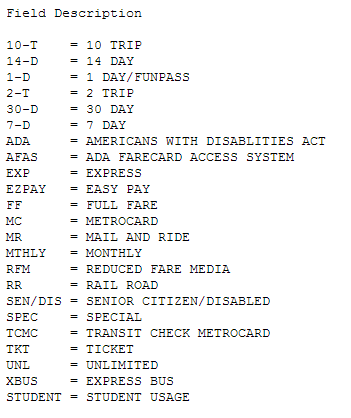

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib import gridspec

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mtarides = np.load("MTA_Fare.npy")

In [3]:
mta = np.load("MTA_Fare.npy")

In [4]:
print ("MTA array shape:", mtarides.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mtarides,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [5]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [6]:
weekdate = pd.date_range(start='05/19/2010', end='02/19/2014', freq='W-WED')
weekdate

DatetimeIndex(['2010-05-19', '2010-05-26', '2010-06-02', '2010-06-09',
               '2010-06-16', '2010-06-23', '2010-06-30', '2010-07-07',
               '2010-07-14', '2010-07-21',
               ...
               '2013-12-18', '2013-12-25', '2014-01-01', '2014-01-08',
               '2014-01-15', '2014-01-22', '2014-01-29', '2014-02-05',
               '2014-02-12', '2014-02-19'],
              dtype='datetime64[ns]', length=197, freq='W-WED')

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


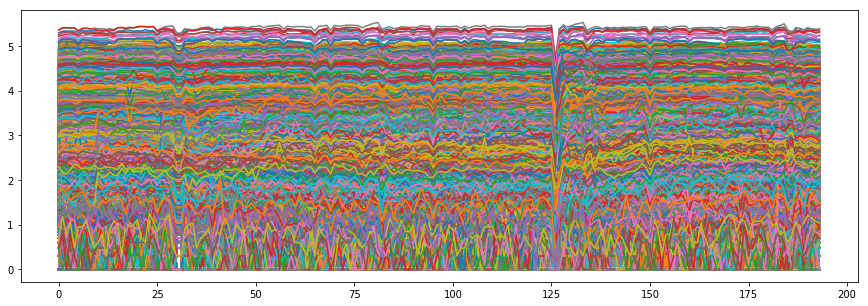

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
for i in range(mtarides.shape[0]):
    for j in range(mtarides.shape[1]):
        ax.plot(log10(mtarides[i,j]))

#### Figure 1: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what  may have caused this event 



In [8]:
mtarides = mtarides.astype(float)
mtarides[np.where(mtarides == -1)] = np.nan

In [9]:
thresholdl = np.zeros((600,23))
thresholdu = np.zeros((600,23))
for i in range(mtarides.shape[0]):
    for j in range(mtarides.shape[1]):
        thresholdl[i,j] = np.nanmean(mtarides[i,j]) - 3 * np.nanstd(mtarides[i,j])
        thresholdu[i,j] = np.nanmean(mtarides[i,j]) + 3 * np.nanstd(mtarides[i,j])

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


In [10]:
for i in range(mtarides.shape[0]):
    for j in range(mtarides.shape[1]):
        if np.where(mtarides[i,j] < thresholdl[i,j])[0] != []:
            if np.where(mtarides[i,j] > thresholdu[i,j])[0] != []:
                print('Prominent High and Low Event for station %.f '%i + 'with subway card type %s is on week'%ridetype[j], 
                  np.where(mtarides[i,j] > thresholdu[i,j])[0], 'and', np.where(mtarides[i,j] < thresholdl[i,j])[0])
            else:
                if np.where(mtarides[i,j] > thresholdu[i,j])[0] == []:
                    print('Prominent Low Event for station %.f '%i + 'with subway card type %s is on week'%ridetype[j], 
                          np.where(mtarides[i,j] < thresholdl[i,j])[0])
        else:
            if np.where(mtarides[i,j] > thresholdu[i,j])[0] != []:
                print('Prominent High Event for station %.f '%i + 'with subway card type %s is on week'%ridetype[j], 
                      np.where(mtarides[i,j] > thresholdu[i,j])[0])

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.
/nfshome/tc1767/.con

Prominent High Event for station 0 with subway card type afas is on week [ 2 28]
Prominent High Event for station 0 with subway card type exp is on week [ 5  7  8  9 10 11]
Prominent High Event for station 0 with subway card type ez is on week [ 5  6  7  8  9 10]
Prominent High Event for station 1 with subway card type afas is on week [ 5 22]
Prominent High Event for station 1 with subway card type mr is on week [47 61]
Prominent High Event for station 2 with subway card type afas is on week [ 3  4 10 28 29]
Prominent High Event for station 2 with subway card type exp is on week [ 2 12 15 19]
Prominent High Event for station 2 with subway card type ff is on week [  1   2  20  41  48 167]
Prominent High Event for station 2 with subway card type tcmc is on week [183 191 192]
Prominent High Event for station 3 with subway card type 30d is on week [ 53  62 137 182]
Prominent High Event for station 3 with subway card type afas is on week [ 6  7 14 15 16 17 20 21]
Prominent High Event for st

Prominent High Event for station 129 with subway card type 1d is on week [ 62 127]
Prominent High Event for station 129 with subway card type ada is on week [ 30  31 127]
Prominent High Event for station 129 with subway card type afas is on week [ 1  3 10 11 20 21 26]
Prominent High Event for station 129 with subway card type exp is on week [16 30 31]
Prominent High Event for station 129 with subway card type ez is on week [11 12]
Prominent High Event for station 129 with subway card type month is on week [ 15 127]
Prominent High Event for station 129 with subway card type rfm is on week [30 31]
Prominent High Event for station 129 with subway card type spec is on week [ 83 100]
Prominent High Event for station 130 with subway card type afas is on week [23 28]
Prominent High Event for station 130 with subway card type ez is on week [27 28]
Prominent High Event for station 130 with subway card type t is on week [ 68 184]
Prominent High Event for station 131 with subway card type t is on

Prominent High Event for station 221 with subway card type afas is on week [ 0  1  2 24 25 26]
Prominent High Event for station 221 with subway card type exp is on week [ 4  5 29]
Prominent High Event for station 221 with subway card type rfm is on week [1 2 3]
Prominent High Event for station 221 with subway card type umlim is on week [  6 146]
Prominent High Event for station 222 with subway card type afas is on week [ 1  2 21 24]
Prominent High Event for station 222 with subway card type ez is on week [27 28]
Prominent High Event for station 223 with subway card type afas is on week [ 0  1  2  3  4 12 29]
Prominent High Event for station 223 with subway card type exp is on week [ 8 21]
Prominent High Event for station 223 with subway card type ez is on week [ 8  9 10 27 28]
Prominent High Event for station 224 with subway card type afas is on week [ 2  5 27]
Prominent High Event for station 224 with subway card type exp is on week [11 29]
Prominent High Event for station 224 with su

Prominent High Event for station 297 with subway card type afas is on week [ 1 12 15 25 26 29]
Prominent High Event for station 297 with subway card type month is on week [125 131]
Prominent High Event for station 298 with subway card type 30d is on week [110 113 114 115 116 117 122]
Prominent High Event for station 298 with subway card type afas is on week [ 3  9 10 20 21 28 29]
Prominent High Event for station 298 with subway card type exp is on week [ 1  4  5  9 10 11 19]
Prominent High Event for station 298 with subway card type ez is on week [27 28]
Prominent High Event for station 298 with subway card type ff is on week [40 50]
Prominent High Event for station 298 with subway card type month is on week [ 78 141 143]
Prominent High Event for station 298 with subway card type tcmc is on week [170 172]
Prominent High Event for station 299 with subway card type afas is on week [ 8 24 26 27 28 29]
Prominent High Event for station 299 with subway card type ez is on week [27 28]
Promine

Prominent High Event for station 373 with subway card type 30d is on week [91 92 94 97]
Prominent High Event for station 373 with subway card type afas is on week [ 1  2  7  9 11]
Prominent High Event for station 373 with subway card type tcmc is on week [160 183]
Prominent High Event for station 374 with subway card type 30d is on week [ 15  57 178 179]
Prominent High Event for station 374 with subway card type afas is on week [14 15 16 17 27 28]
Prominent High Event for station 374 with subway card type ff is on week [165 179]
Prominent High Event for station 374 with subway card type rr is on week [178 179 193]
Prominent High Event for station 375 with subway card type 2t is on week [53 54 56]
Prominent High Event for station 375 with subway card type afas is on week [15 16 18 28]
Prominent High Event for station 375 with subway card type mc is on week [164 165]
Prominent High Event for station 375 with subway card type month is on week [ 11 109]
Prominent High Event for station 376

Prominent High Event for station 447 with subway card type afas is on week [ 1  5  6  7  8 11 13 15]
Prominent High Event for station 447 with subway card type exp is on week [17 21]
Prominent High Event for station 447 with subway card type ez is on week [23 24 27]
Prominent High Event for station 447 with subway card type ff is on week [162 164 165 166 187 190]
Prominent High Event for station 447 with subway card type mc is on week [180 182]
Prominent High Event for station 447 with subway card type month is on week [ 98 119 172]
Prominent High Event for station 447 with subway card type rr is on week [ 92 101 102]
Prominent High Event for station 447 with subway card type tcmc is on week [175 177 178 180 182 183]
Prominent High Event for station 448 with subway card type 30d is on week [ 87  89 192]
Prominent High Event for station 448 with subway card type afas is on week [21 23 24 28 30 31]
Prominent High Event for station 448 with subway card type exp is on week [ 2  4 10]
Promi

In [11]:
for i in range(mtarides.shape[0]):
    for j in range(mtarides.shape[1]):
        if np.where(mtarides[i,j] < thresholdl[i,j])[0] != []:
            print('Prominent Drop for station %.f '%i + 'with subway card type %s is on week'%ridetype[j], 
                          np.where(mtarides[i,j] < thresholdl[i,j])[0])

Prominent Drop for station 0 with subway card type 10t is on week [127 130]
Prominent Drop for station 0 with subway card type 14d is on week [126 127 130]
Prominent Drop for station 0 with subway card type 1d is on week [127 130]
Prominent Drop for station 0 with subway card type 2t is on week [126 127 130 131]
Prominent Drop for station 0 with subway card type 7d is on week [127 130]
Prominent Drop for station 0 with subway card type ada is on week [127 130]
Prominent Drop for station 0 with subway card type mc is on week [126 127 130]
Prominent Drop for station 0 with subway card type rr is on week [127 130]
Prominent Drop for station 9 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 11 with subway card type ada is on week [126 186]
Prominent Drop for station 12 with subway card type ada is on week [ 30  31 126 134 185]
Prominent Drop for station 13 with subway card type ada is on week [126 134]
Prominent Drop for station 14 with subway card type 10t is

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  This is separate from the ipykernel package so we can avoid doing imports until


Prominent Drop for station 54 with subway card type 10t is on week [126 193]
Prominent Drop for station 54 with subway card type 2t is on week [126 193]
Prominent Drop for station 54 with subway card type ada is on week [126 193]
Prominent Drop for station 55 with subway card type 7d is on week [ 30  31 126]
Prominent Drop for station 55 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 56 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 57 with subway card type ada is on week [126 134 185]
Prominent Drop for station 58 with subway card type ada is on week [ 82 126 134 185]
Prominent Drop for station 58 with subway card type mc is on week [126 134]
Prominent Drop for station 59 with subway card type ada is on week [126 134]
Prominent Drop for station 61 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 61 with subway card type month is on week [126 185]
Prominent Drop for station 69 with subway card ty

Prominent Drop for station 228 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 229 with subway card type 2t is on week [126 127]
Prominent Drop for station 229 with subway card type ada is on week [ 30  31 126]
Prominent Drop for station 230 with subway card type ada is on week [126 134 185]
Prominent Drop for station 231 with subway card type month is on week [126 159 160]
Prominent Drop for station 233 with subway card type 10t is on week [ 69 126]
Prominent Drop for station 234 with subway card type 10t is on week [126 127]
Prominent Drop for station 234 with subway card type 14d is on week [126 127]
Prominent Drop for station 234 with subway card type 1d is on week [126 127]
Prominent Drop for station 234 with subway card type 2t is on week [ 30  31 126 127]
Prominent Drop for station 234 with subway card type ada is on week [ 30  31 126 127]
Prominent Drop for station 235 with subway card type 10t is on week [126 127]
Prominent Drop for station 235 wi

Prominent Drop for station 399 with subway card type rr is on week [111 126]
Prominent Drop for station 400 with subway card type 10t is on week [149 156 158 159 165 166]
Prominent Drop for station 400 with subway card type 14d is on week [149 156 158 159 165 166]
Prominent Drop for station 400 with subway card type 2t is on week [149 156 158 159 165 166]
Prominent Drop for station 400 with subway card type 7d is on week [149 156 158 159 165 166]
Prominent Drop for station 400 with subway card type ada is on week [149 156 158 159 165 166]
Prominent Drop for station 401 with subway card type 10t is on week [126 132]
Prominent Drop for station 401 with subway card type 14d is on week [126 132]
Prominent Drop for station 401 with subway card type 2t is on week [126 132]
Prominent Drop for station 401 with subway card type 7d is on week [126 132]
Prominent Drop for station 401 with subway card type ada is on week [126 132]
Prominent Drop for station 401 with subway card type rfm is on week

In [12]:
print(weekdate[30], weekdate[31])
print("The significant drop of number of swipes in December 2010 is due to a major Blizzard.")
print(weekdate[126], weekdate[127])
print("The significant drop of number of swipes in October 2012 is due to Hurricane Sandy.")

2010-12-15 00:00:00 2010-12-22 00:00:00
The significant drop of number of swipes in December 2010 is due to a major Blizzard.
2012-10-17 00:00:00 2012-10-24 00:00:00
The significant drop of number of swipes in October 2012 is due to Hurricane Sandy.


 # 2: finding trends

## NOTE ON THE TREND DETECTION:
### you should find the *ride type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [13]:
ridetype

array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
       'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
       'umlim', 'xbus', 'stud'], dtype='<U5')

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1440x1440 with 0 Axes>

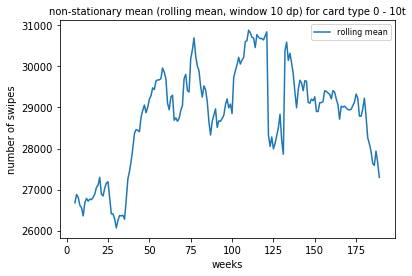

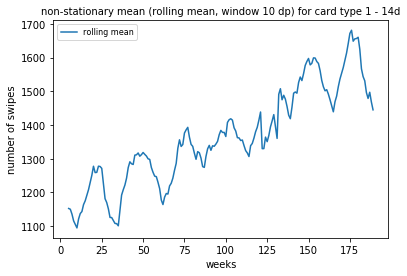

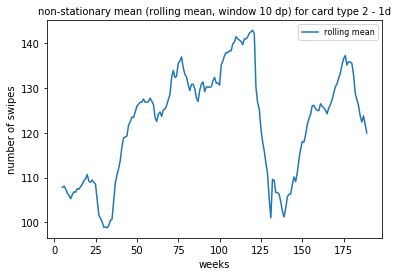

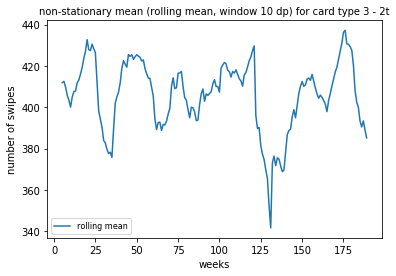

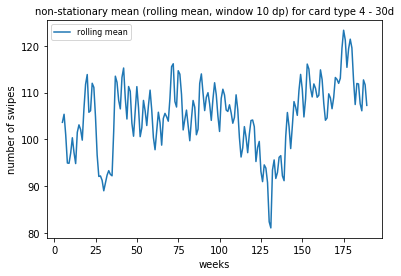

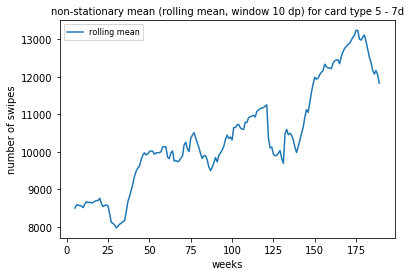

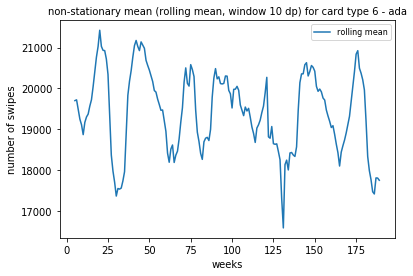

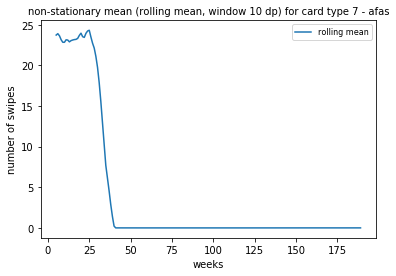

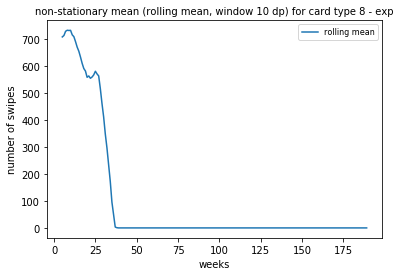

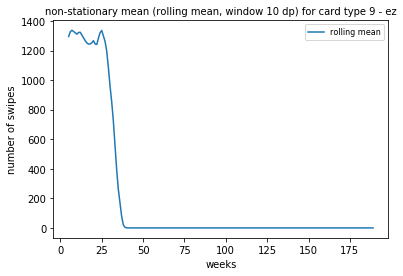

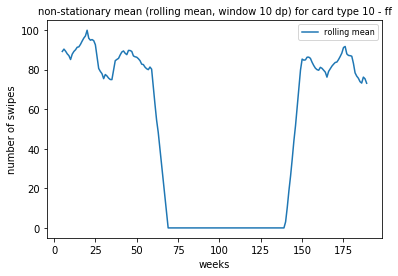

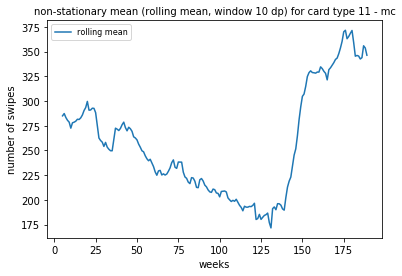

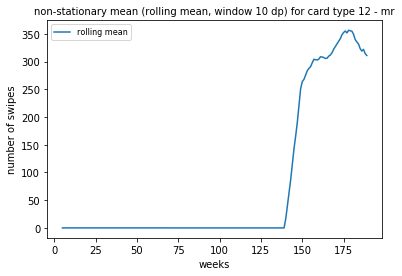

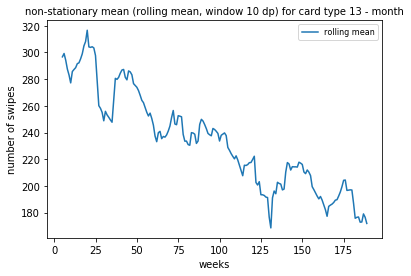

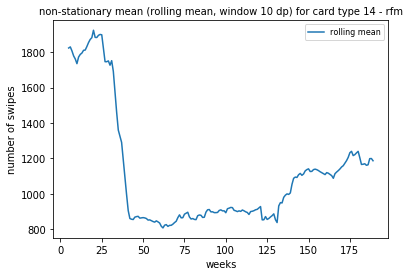

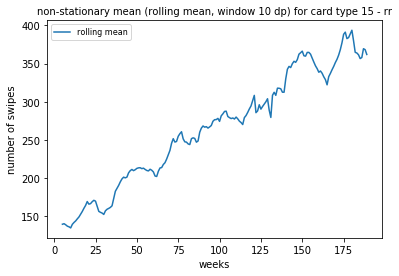

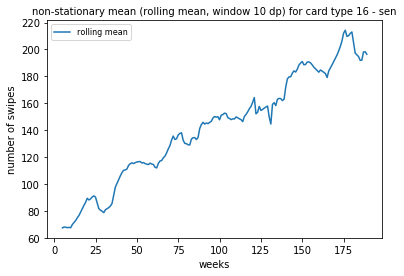

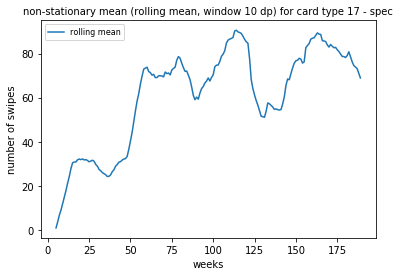

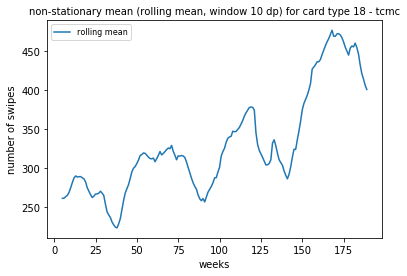

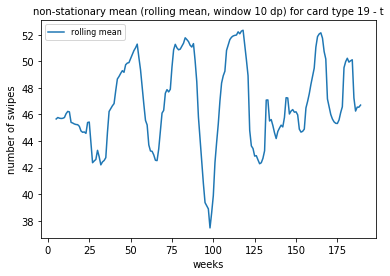

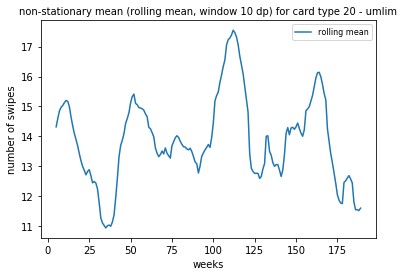

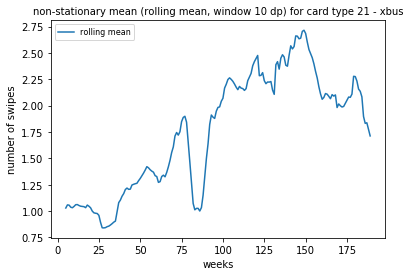

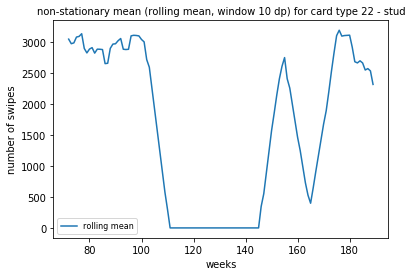

In [14]:
ridetype_mean = pd.DataFrame(np.nanmean(mtarides, axis=0).T)
for i in range(mtarides.shape[1]):
    ridetype_mean['rolling_%d'%i] = ridetype_mean[i].rolling(10, center = True).mean()

fig = plt.figure(figsize=(20,20))
for i in range(mtarides.shape[1]):
    plt.figure()
    plt.plot(np.arange(len(ridetype_mean[i])), ridetype_mean['rolling_%d'%i], label="rolling mean")
    pl.title("non-stationary mean (rolling mean, window 10 dp) for card type %d - %s" %(i,ridetype[i]), fontsize=10)
    pl.xlabel("weeks", fontsize=10)
    pl.ylabel("number of swipes", fontsize=10)
    pl.legend(fontsize=8)



#### Figure 2: Each plot represents number of swipes from 05/19/2010 to 02/19/2014 for each type of cards.

In [15]:
ratio = np.zeros(23)
for i in range(len(ratio)):
    ratio[i] = (ridetype_mean['rolling_%d'%i][189] - ridetype_mean['rolling_%d'%i][5]) / ridetype_mean['rolling_%d'%i][5]

In [16]:
ratio[22] = (ridetype_mean['rolling_22'][189] - ridetype_mean['rolling_22'][72]) / ridetype_mean['rolling_22'][72]

In [17]:
ridetype_std = np.zeros(23)
for i in range(23):
    ridetype_std[i] = ridetype_mean['rolling_%d'%i].std()

After inspecting by eye and combining change ratio, the steepest increase is card type senior citizens/ disabled with change ratio 1.91 and the steepest decrease is card type monthly with change ratio -0.42.


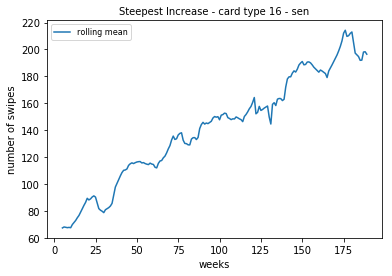

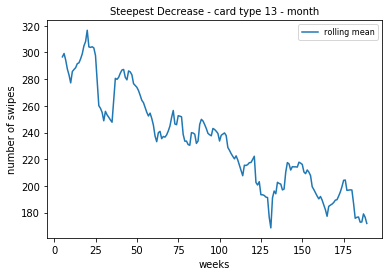

In [18]:

plt.figure()
plt.plot(np.arange(len(ridetype_mean[16])), ridetype_mean['rolling_16'], label="rolling mean")
pl.title("Steepest Increase - card type 16 - sen" , fontsize=10)
pl.xlabel("weeks", fontsize=10)
pl.ylabel("number of swipes", fontsize=10)
pl.legend(fontsize=8)

plt.figure()
plt.plot(np.arange(len(ridetype_mean[13])), ridetype_mean['rolling_13'], label="rolling mean")
pl.title("Steepest Decrease - card type 13 - month" , fontsize=10)
pl.xlabel("weeks", fontsize=10)
pl.ylabel("number of swipes", fontsize=10)
pl.legend(fontsize=8)

print(
    "After inspecting by eye and combining change ratio, the steepest increase is", 
    "card type senior citizens/ disabled with change ratio %.2f"%ratio[16], 
    "and the steepest decrease is card type monthly with change ratio %.2f."%ratio[13])

#### Figure 3: First plot represents type of card which is Senior Citizens/ Disabled that has steepest increase in number of swipes from 05/19/2010 to 02/19/2014. Second plot represents type of card which is Monthly that has steepest decrease in number of swipes from 05/19/2010 to 02/19/2014.

# 3. Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

In [19]:
label = np.concatenate([np.array(range(23)) for i in range(600)])[mtarides.reshape(600*23, 194).std(1) > 0]
label.shape

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(7660,)

In [20]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [21]:
stationsmeans = np.nanmean(np.nanmean(mtarides, axis=1),axis=1)
stationsstd = np.nanstd(np.nanmean(mtarides, axis=1),axis=1)

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [22]:
stationsmeans.shape

(600,)

In [23]:
stationsstd.shape

(600,)

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN
Here is how you would use to only extract station id for the valid (no containing nan) time series


In [24]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid = stationid[mtarides.reshape(600*23, 194).std(1) > 0]    #There are 14 station 550

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [25]:
stationid.shape

(7660,)

In [26]:
tots = mta.reshape(600*23, 194)[mtarides.reshape(600*23, 194).std(1) > 0]
tots.shape

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(7660, 194)

In [27]:
normed_mta = np.zeros((7660, 194))
for i in range(7660):
        normed_mta[i] = (tots[i] - stationsmeans[stationid[i]]) / stationsstd[stationid[i]]

In [28]:
normedtsmean = np.zeros(7660)
for i in range(7660):
    normedtsmean[i] = np.mean(normed_mta[i])

In [29]:
normedtsstd = np.zeros(7660)
for i in range(7660):
    normedtsstd[i] = np.std(normed_mta[i])

In [30]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape

(7660,)

In [31]:
tsmean[:10]

array([3.54891753e+03, 1.44587629e+02, 1.79381443e+01, 3.02577320e+01,
       2.89690722e+00, 1.72666495e+03, 1.25873711e+03, 3.86597938e-01,
       4.62886598e+00, 3.00618557e+01])

In [32]:
tsstdev = np.nanstd(tots, axis=1)
tsstdev.shape

(7660,)

In [33]:
tsstdev[:10]

array([391.40042433,  43.60075488,   8.13711673,   9.80981872,
         4.23530701, 286.20893188, 182.35136007,   1.22685827,
        11.1163663 ,  67.14683317])

In [34]:
standardizedts = np.zeros((7660, 194))
for i in range(7660):
    standardizedts[i] = (tots[i] - tsmean[i]) / tsstdev[i]

Text(0,0.5,'standardized number of rides')

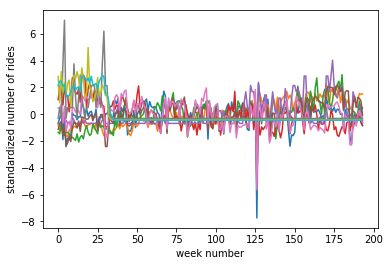

In [35]:
standardizedts = pd.DataFrame(standardizedts.T)
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

#### Figure4: Standardizes number of rides for time series from 05/19/2010 to 02/19/2014. We can see that there is a sharp drop at around week 130 which is when Hurrican Sandy occured.

In [36]:
allfits = []
for i in range(7660):
    allfits.append(sm.OLS(tots[i], sm.add_constant(np.array(range(194)))).fit())
[a.params[0] for a in allfits[:10]]

[3545.2318794607445,
 81.16034892942108,
 9.239016653449642,
 40.72656621728786,
 -1.4374306106264856,
 1477.271371927042,
 1363.03425852498,
 1.3029341792228388,
 16.24155432196669,
 104.1636796193497]

You can use the sklearn train_test_split() function to create your training and test dataset. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              tsmean/normedtsmean, tsstdev/normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [38]:
np.array(X_train).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_test).shape

((5132, 4), (2528, 4), (5132,), (2528,))

depending on the details of your data processing you may have infinities as well. You also will have to get read of them

In [39]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(0, 0, 0, 0)

In [40]:
X_test[~np.isfinite(X_test)] = 0

In [41]:
X_train[~np.isfinite(X_train)] = 0

In [42]:
clf = rfc()
clf.fit(X_train, y_train)

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
y_pred = clf.predict(X_test)

and use sklearn confusion_matrix to see the errors

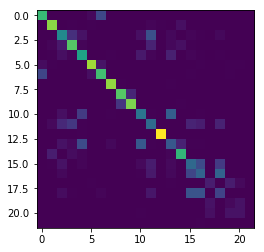

In [44]:
imshow(confusion_matrix(y_test, y_pred))

#### Figure5: Card type 0 to 15 are predicted quite well from the model while card type 15 to 20 starts to occur some false positive and false negative.

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       135
           1       0.85      0.92      0.88       133
           2       0.53      0.47      0.50       148
           3       0.65      0.74      0.69       147
           4       0.53      0.69      0.60       124
           5       0.92      0.88      0.90       144
           6       0.71      0.73      0.72       142
           7       0.96      0.98      0.97       126
           8       0.82      0.87      0.84       125
           9       0.88      0.83      0.86       143
          10       0.47      0.42      0.44       137
          11       0.37      0.37      0.37       138
          12       0.99      0.99      0.99       149
          13       0.35      0.27      0.31       146
          14       0.78      0.82      0.80       119
          15       0.35      0.36      0.36       138
          16       0.34      0.33      0.34       142
          17       0.48    

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 and use classification_report to assess the model and clf.feature_importances_ to find the important features

In [46]:
importances = clf.feature_importances_
importances

array([0.24616957, 0.29562651, 0.27958103, 0.17862288])

Feature ranking:
1. feature 1 (0.295627)
2. feature 2 (0.279581)
3. feature 0 (0.246170)
4. feature 3 (0.178623)


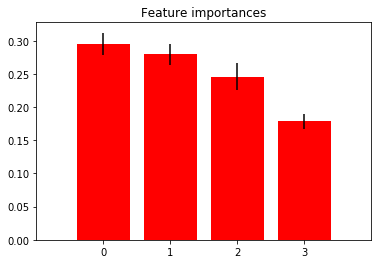

In [47]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pl.figure()
pl.title("Feature importances")
pl.bar(range(X_test.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pl.xticks(range(X_test.shape[1]))
pl.xlim([-1, X_test.shape[1]])

pl.show()

#### Figure6: Two most important features are feature 1 and feature 2 which is the slope of the line fits to the standardized time series and the time series mean divided by the mean of all time series for that station.

## Build a model that uses as input features each time stamp (194 features) :


In [48]:
# use the same split ratio
X_train, X_test, y_train, y_test = train_test_split(tots, label, test_size=0.33, random_state=42, shuffle=True)

In [49]:
clf = rfc()
clf.fit(X_train, y_train)

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
y_pred = clf.predict(X_test)

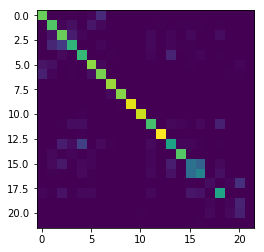

In [51]:
imshow(confusion_matrix(y_test, y_pred))

#### Figure7: Card type 0 to 15 are predicted quite well from the model while card type 15 to 20 starts to occur some false positive and false negative but slightly better than previous model with four engineering features. 

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       135
           1       0.73      0.81      0.77       133
           2       0.65      0.78      0.71       148
           3       0.75      0.66      0.70       147
           4       0.68      0.80      0.73       124
           5       0.83      0.85      0.84       144
           6       0.80      0.83      0.81       142
           7       0.95      1.00      0.98       126
           8       0.99      0.97      0.98       125
           9       1.00      0.99      1.00       143
          10       0.99      0.99      0.99       137
          11       0.83      0.76      0.79       138
          12       0.99      0.99      0.99       149
          13       0.68      0.59      0.63       146
          14       0.95      0.92      0.93       119
          15       0.43      0.40      0.41       138
          16       0.52      0.46      0.49       142
          17       0.50    

/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/nfshome/tc1767/.conda/envs/myEnv1/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
importances = clf.feature_importances_
importances

array([0.00991856, 0.0088677 , 0.00622433, 0.00742314, 0.01077665,
       0.00915776, 0.01021195, 0.01161753, 0.00424416, 0.01810905,
       0.00845256, 0.00405524, 0.01358902, 0.0123937 , 0.00880532,
       0.00442665, 0.00858429, 0.01162644, 0.00625829, 0.00596362,
       0.00522765, 0.0123531 , 0.00391839, 0.00442817, 0.00383637,
       0.00464644, 0.01155485, 0.00960023, 0.00441102, 0.0101564 ,
       0.01103509, 0.0079069 , 0.01643137, 0.01133716, 0.01446964,
       0.01967872, 0.00147665, 0.00905586, 0.00410343, 0.00556292,
       0.007354  , 0.01043672, 0.00639946, 0.003294  , 0.00301541,
       0.00291361, 0.0034713 , 0.00181113, 0.00834249, 0.00201752,
       0.00133951, 0.00715256, 0.00243656, 0.00598532, 0.00098193,
       0.00130122, 0.00172281, 0.00156917, 0.00215493, 0.00615668,
       0.00798546, 0.00779478, 0.0208543 , 0.00112021, 0.0008087 ,
       0.00217016, 0.00104686, 0.0068499 , 0.00115603, 0.00272681,
       0.00703075, 0.00700139, 0.00142838, 0.00679129, 0.00111

In [54]:
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(2):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 62 (0.020854)
2. feature 35 (0.019679)


#### Two most important features are feature 34 and feature 41 which is week 34 and week 41 between 05/19/2010 and 02/19/2014.